In [14]:
import numpy as np
import scipy as sp
from scipy.spatial.distance import squareform
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDrawingArea
from mpl_toolkits import axes_grid1

import pandas as pd
import seaborn as sns
import os
import itertools
from nilearn.plotting import plot_connectome, view_connectome, view_markers
%matplotlib inline

In [15]:
data_dir = '/data/HCP_preproc/7T_movie/cpm/results/masks/'

In [16]:
behav_list = ["cognPC1", "emotPC1"]

run_list = ["REST1", "MOVIE1", "MOVIE2", "REST4", "MOVIE3", "MOVIE4"]

## Draw brain figures

In [17]:
def load_masks(clip, behav, gsr="1", zscore="0", trs=None, data_dir='/data/HCP_preproc/7T_movie/cpm/results/masks/', verbose=True):
    
    file_stem = "clip-" + clip + "_behav-" + behav + "_gsr-" + gsr + "_zscore-" + zscore + "_rthr-0.2_k-10"
    if trs is not None:
        file_stem = file_stem + '_trs-' + str(trs)
    
    pos_file = file_stem + '_tail-pos.txt'
    neg_file = file_stem + '_tail-neg.txt'
    
    pos_mask = np.genfromtxt(data_dir + pos_file, delimiter=',')
    neg_mask = np.genfromtxt(data_dir + neg_file, delimiter=',')

    if verbose is True:
        print("Shape of pos mask: {}".format(pos_mask.shape))
        print("Shape of neg mask: {}".format(neg_mask.shape))

    pos_mask = pos_mask.mean(axis=0)
    neg_mask = neg_mask.mean(axis=0)

    if verbose is True:
        print(pos_mask.shape)
        print(neg_mask.shape)
    
    return pos_mask, neg_mask

In [18]:
behav = "cognPC1"
gsr = "1"
zscore = "0"

mask_dict = {}

run_list = ["REST1", "MOVIE1", "MOVIE2", "REST4", "MOVIE3", "MOVIE4"]

clip_list = ["twomen", "bridgeville", "pockets", # "overcome", "testretest1",
              "inception", "socialnet", "oceans", # "testretest2",
              "flower", "hotel", "garden", "dreary", # "testretest3",
              "homealone", "brokovich", "starwars", # "testretest4"  
        ]

for clip in run_list:
    print(clip)
    mask_dict[clip] = {}
    pos_mask, neg_mask = load_masks(clip=clip, behav=behav, gsr=gsr, zscore=zscore, verbose=True)
    mask_dict[clip]["pos_mask"] = pos_mask
    mask_dict[clip]["neg_mask"] = neg_mask
    
for clip in clip_list:
    print(clip)
    mask_dict[clip] = {}
    pos_mask, neg_mask = load_masks(clip=clip, behav=behav, gsr=gsr, zscore=zscore, trs=143, verbose=True)
    mask_dict[clip]["pos_mask"] = pos_mask
    mask_dict[clip]["neg_mask"] = neg_mask

REST1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
MOVIE1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
MOVIE2
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
REST4
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
MOVIE3
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
MOVIE4
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
twomen
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
bridgeville
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
pockets
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
inception
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
socialnet
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
oceans
Shap

In [6]:
def get_masks(clip, thresh = 0.9, mask_dict = mask_dict):

    if len(clip)==1:
        pos_mask = mask_dict[clip[0]]["pos_mask"] > thresh
        neg_mask = mask_dict[clip[0]]["neg_mask"] > thresh

        print("No pos edges: {}".format(pos_mask.sum()))
        print("No neg edges: {}".format(neg_mask.sum()))

    elif len(clip)>1: # For combining multiple masks
        pos_mask = []
        neg_mask = []
        for c,c_name in enumerate(clip):
            print(c_name)
            if c==0:
                pos_mask = mask_dict[c_name]["pos_mask"] > thresh
                neg_mask = mask_dict[c_name]["neg_mask"] > thresh
                print("No pos edges: {}".format(pos_mask.sum()))
                print("No neg edges: {}".format(neg_mask.sum()))

            elif c>0:
                tmp_pos = mask_dict[c_name]["pos_mask"] > thresh
                tmp_neg = mask_dict[c_name]["neg_mask"] > thresh

                print("No pos edges: {}".format(tmp_pos.sum()))
                print("No neg edges: {}".format(tmp_neg.sum()))

                pos_mask = np.logical_and(pos_mask, tmp_pos)
                neg_mask = np.logical_and(neg_mask, tmp_neg)
    
    print("Overall no pos edges: {}".format(pos_mask.sum()))
    print("Overall no neg edges: {}".format(neg_mask.sum()))
                
    return pos_mask, neg_mask

In [7]:
def plot_important_nodes(pos_mask, neg_mask, 
                         thresh=0.9, 
                         fig=None, 
                         cmap = 'RdYlBu_r', 
                         display_mode='lr', 
                         size_factor=2, 
                         norm_size=False, 
                         draw_edges=False
                        ):

    if thresh is not None:
        combo_mask = np.zeros_like(pos_mask)
        combo_mask[pos_mask>thresh] = 1
        combo_mask[neg_mask>thresh] = -1
        combo_mask[(pos_mask < thresh) & (neg_mask<thresh)] = np.nan
    elif thresh is None: # assume pos_mask and neg_masks are booleans that have already been thresholded
        combo_mask = np.zeros(pos_mask.shape)
        combo_mask[pos_mask] = 1
        combo_mask[neg_mask] = -1
        combo_mask[~pos_mask & ~neg_mask] = np.nan

    n_edges = np.nansum(abs(sp.spatial.distance.squareform(combo_mask)), axis=0)
    node_color = np.nansum(sp.spatial.distance.squareform(combo_mask), axis=0)
    
    if norm_size is True:
        node_size = (n_edges/max(abs(n_edges)))*size_factor
    else:
        node_size = n_edges*size_factor
    
    
    if draw_edges is False:
        data = sp.spatial.distance.squareform(np.zeros_like(pos_mask)) # generate dummy edge data (since we're not actually drawing edges)
        linewidth = 0
    elif draw_edges is True:
        data = sp.spatial.distance.squareform(combo_mask)
        linewidth = 1

        
    if fig is None:
        fig = plt.figure(facecolor='lightgray')
        
    ax = fig.add_axes([0,0,1,1])

    # vmin = -np.max(abs(node_color))
    # vmax = np.max(abs(node_color))

    vmin = -1
    vmax = 1

    cmap = mpl.cm.get_cmap(cmap)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    my_cmap = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    
    display = plot_connectome(adjacency_matrix=data, 
                    node_coords=shen268_labels[['MNI_X', 'MNI_Y', 'MNI_Z']],
                   node_color = node_color/max(abs(node_color)), # rescale number of edges to be between -1 and 1
                    edge_kwargs={'linewidth': linewidth},
                    edge_cmap = cmap,
                   node_size=node_size,
                   display_mode=display_mode,
                    node_kwargs={'cmap': cmap, 'norm': norm},
                    figure = fig,
                    axes = ax
                   )
    
    # cbar = display._show_colorbar(cmap, norm)
    # cbar = fig.colorbar(display)
    # cbar.ax.set_yticks([-1, 0, 1])
    # cbar.ax.set_yticklabels(['More +ve edges', 'Equal +ve/-ve.', 'More -ve edges']), 

    return fig, cmap, norm, combo_mask, n_edges, node_size

In [8]:
shen268_labels = pd.read_csv('../data/xilin_268parc_labels.csv')
shen268_labels.drop(columns=['IGNORE'], inplace=True)
shen268_labels.head()

,Node_No,MNI_X,MNI_Y,MNI_Z,Lobe,Network,BrodLabel
0,1,13.9,56.8,-16.6,1,5,11
1,2,9.6,17.8,-19.5,1,13,11
2,3,5.1,34.9,-17.4,1,13,11
3,4,15.6,34.1,-22.6,1,13,11
4,5,8.2,45.9,-1.7,1,5,10


No pos edges: 84
No neg edges: 76
Overall no pos edges: 84
Overall no neg edges: 76


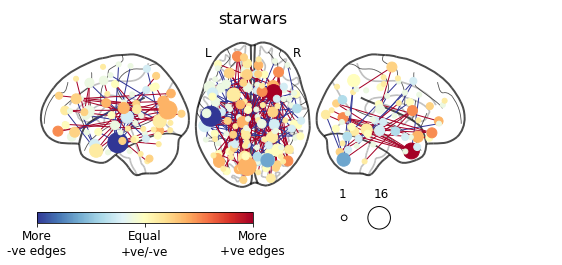

In [13]:
# clip=["REST1", "REST4"]
# clip=["MOVIE1", "MOVIE2"]
# clip=["MOVIE3", "MOVIE4"]
clip = ["starwars"]

behav="cognPC1"
thresh=None
gsr="1"
zscore="0"
trs=None
norm_size=True
draw_edges=True
size_factor = 400 # 20 is a good one if norm_size=False, 200 is a good one if norm_size=True
add_cbar=True
display_mode='lzr'
# ----------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(6,3), facecolor='white')

# pos_mask, neg_mask = load_masks(clip=clip, behav=behav, gsr=gsr, zscore=zscore, trs=trs)
pos_mask, neg_mask = get_masks(clip=clip)

fig, cmap, norm, combo_mask, n_edges, node_size = plot_important_nodes(pos_mask, neg_mask, 
                                                                       fig=fig, 
                                                                       thresh=thresh, 
                                                                       norm_size=norm_size, 
                                                                       size_factor=size_factor,
                                                                       draw_edges=draw_edges,
                                                                       display_mode=display_mode)
# fig.suptitle(clip + "_" + behav)
if len(clip)==1:
    title = clip[0]
elif len(clip) >1:
    title = [clip[0] + ''.join([' & ', x]) for x in clip[1:]][0]
    
fig.suptitle(title, fontsize=16)
             
# make separate colorbar
if add_cbar is True:
    ax2 = fig.add_axes([0,0,0.5,0.05])
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(['More\n-ve edges', 'Equal\n+ve/-ve', 'More\n+ve edges'])
    cbar.ax.tick_params(labelsize='large')


# draw size key
ax3 = fig.add_axes([0.7,0,0.5,0.02])
ada = AnchoredDrawingArea(100, 5, 0, 0,
                          loc='lower left', pad=0., frameon=False)

ax3.axis('off')

# if norm_size is True:
#     max_edges = int(np.max(((node_size/size_factor)*max(abs(node_size))))
#     min_edges = int(np.min(node_size[node_size > 0]/size_factor*max(abs(node_size))))
#     mean_edges = int(np.mean(node_size[node_size > 0]/size_factor*max(abs(node_size))))
# if norm_size is False:
#    max_edges = int(np.max(node_size/size_factor))
#     min_edges = int(np.min(node_size[node_size > 0]/size_factor))
#     mean_edges = int(np.mean(node_size[node_size > 0]/size_factor))


max_edges = int(np.max(n_edges))
min_edges = int(np.min(n_edges[n_edges > 0]))
mean_edges = int(np.mean(n_edges[n_edges > 0]))

r_max = np.sqrt(np.max(node_size)/math.pi)
r_min = np.sqrt(np.min(node_size[node_size > 0])/math.pi)
r_mean = np.sqrt(np.mean(node_size[node_size > 0])/math.pi)

p1 = Circle((0, 0), r_min, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p1)
p2 = Circle((35, 0), r_max, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p2)
# p3 = Circle((80, 0), r_max, edgecolor = 'black', facecolor='white')
# ada.drawing_area.add_artist(p3)

ax3.add_artist(ada)

fontsize=12
ax3.annotate(str(min_edges), 
                xy=(0, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='left')
             
ax3.annotate(str(max_edges), 
                 xy=(35, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='left')
             
# ax3.annotate(str(max_edges), 
#                xy=(80, 25), 
#                xycoords='axes points', 
#             fontsize=fontsize, horizontalalignment='center')

# ax3.text(0.3, 0.8, 'Number of edges', verticalalignment='bottom', horizontalalignment='center', transform=ax3.transAxes, fontsize=fontsize)

#ax3.text('Number of edges', 
#                   xy=(25, 2), 
#                   xycoords='axes pixels')

# fig.tight_layout()
fig.savefig(title + '_' + behav + '.jpg', dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

In [37]:
np.argsort(n_edges)[::-1]+1

array([196, 215,  51, 112, 189, 211, 191,  43, 264,  18, 203,  68, 156,
        95, 152,  26, 187,  17, 139, 121, 219,  74, 127,   5, 227, 165,
       260,  64, 208, 206, 140, 197, 149, 150, 155, 137,  66, 106,  78,
        77, 254, 201, 248, 143, 250, 195, 145,  92, 188,  83,  73, 204,
       182, 257, 178, 177, 158, 175,  45,  46,  54,  52, 100, 105, 217,
         3,  72,  63,  28,  21, 110, 234, 263, 212,  76,  70, 225,   4,
        88, 122, 123,  75, 160, 162,  53, 154,  80, 153, 128, 108, 113,
        67, 102,  93, 148, 147,  82, 267, 119,  79, 138,  57,  89, 166,
         9,  33, 200, 202,  32, 244, 207, 209, 210, 213,  31,  14,  15,
       220,  27, 239, 223, 233,  10, 230, 265, 252, 192, 253,   8,  48,
        47, 181, 174, 251,  90,  81,   2,  20,  19,  16,  87,   6,   7,
        13,  86,  85,  84,  12,  22,  11,  29,  23,  58,  49,  55,  44,
        56,  42,  41,  40,  39,  38,  37,  36,  35,  24,  59,  34,  60,
        61,  62,  65,  30,  50,  69,  71,  25, 268, 134,  91, 17

In [38]:
n_edges[np.argsort(n_edges)[::-1]]

array([16., 13., 10.,  7.,  7.,  7.,  6.,  6.,  5.,  5.,  5.,  5.,  5.,
        4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

## Draw Hinton plots

In [100]:
shen268_labels = pd.read_csv('../data/xilin_268parc_labels.csv')
shen268_labels.drop(columns=['IGNORE'], inplace=True)
shen268_labels.head()

,Node_No,MNI_X,MNI_Y,MNI_Z,Lobe,Network,BrodLabel
0,1,13.9,56.8,-16.6,1,5,11
1,2,9.6,17.8,-19.5,1,13,11
2,3,5.1,34.9,-17.4,1,13,11
3,4,15.6,34.1,-22.6,1,13,11
4,5,8.2,45.9,-1.7,1,5,10


In [101]:
shen268_networks = pd.read_csv('../data/shen_268_parcellation_networklabels.csv')
shen268_labels["Network2"] = shen268_networks["Network"]
shen268_labels.head()

,Node_No,MNI_X,MNI_Y,MNI_Z,Lobe,Network,BrodLabel,Network2
0,1,13.9,56.8,-16.6,1,5,11,2
1,2,9.6,17.8,-19.5,1,13,11,4
2,3,5.1,34.9,-17.4,1,13,11,3
3,4,15.6,34.1,-22.6,1,13,11,2
4,5,8.2,45.9,-1.7,1,5,10,3


In [102]:
lobe_lookup = {
	1: 'R-Prefrontal',
	2: 'R-MotorStrip',  3: 'R-Insula',
	4: 'R-Parietal',    5: 'R-Temporal',
	6: 'R-Occipital',   7: 'R-Limbic',
	8: 'R-Cerebellum',  9: 'R-Subcortical',
	10: 'R-Brainstem', 11: 'L-Prefrontal',
	12: 'L-MotorStrip',13: 'L-Insula',
	14: 'L-Parietal',  15: 'L-Temporal',
	16: 'L-Occipital', 17: 'L-Limbic',
	18: 'L-Cerebellum',19: 'L-Subcortical',
	20: 'L-Brainstem' };

network_lookup = {
    1: 'Medial frontal',
    2: 'Frontoparietal',  
    3: 'Default mode',
    4: 'Subcort-cereb',    
    5: 'Motor',
    6: 'Visual I',   
    7: 'Visual II',
    8: 'Visual assoc'
}

In [103]:
shen268_labels['Lobe'] = shen268_labels['Lobe'].replace(lobe_lookup)
shen268_labels['Network2'] = shen268_labels['Network2'].replace(network_lookup)
shen268_labels['BilatLobe'] = [x.split('-')[1] for x in shen268_labels['Lobe']]
shen268_labels.head()

,Node_No,MNI_X,MNI_Y,MNI_Z,Lobe,Network,BrodLabel,Network2,BilatLobe
0,1,13.9,56.8,-16.6,R-Prefrontal,5,11,Frontoparietal,Prefrontal
1,2,9.6,17.8,-19.5,R-Prefrontal,13,11,Subcort-cereb,Prefrontal
2,3,5.1,34.9,-17.4,R-Prefrontal,13,11,Default mode,Prefrontal
3,4,15.6,34.1,-22.6,R-Prefrontal,13,11,Frontoparietal,Prefrontal
4,5,8.2,45.9,-1.7,R-Prefrontal,5,10,Default mode,Prefrontal


In [105]:
def summarize_masks(pos_mask, neg_mask, group_by='BilatLobe'):

    # Make masks square DFs
    pos_mask_df = pd.DataFrame(sp.spatial.distance.squareform(pos_mask))
    neg_mask_df = pd.DataFrame(sp.spatial.distance.squareform(neg_mask))

    # Relabel them as networks
    pos_mask_nws = pos_mask_df.rename(mapper=shen268_labels[group_by], axis=0)
    pos_mask_nws = pos_mask_nws.rename(mapper=shen268_labels[group_by], axis=1)

    neg_mask_nws = neg_mask_df.rename(mapper=shen268_labels[group_by], axis=0)
    neg_mask_nws = neg_mask_nws.rename(mapper=shen268_labels[group_by], axis=1)

    nws = pos_mask_nws.index.unique().values

    pos_summary = pd.DataFrame(index=nws, columns=nws)
    for i,nw1 in enumerate(nws):
        for j,nw2 in enumerate(nws):
            if i==j:
                pos_summary.loc[nw1,nw2] = pos_mask_nws.loc[nw1,nw2].sum().sum()/2 # control for symmetry
            else:
                pos_summary.loc[nw1,nw2] = pos_mask_nws.loc[nw1,nw2].sum().sum()

    neg_summary = pd.DataFrame(index=nws, columns=nws)
    for i,nw1 in enumerate(nws):
        for j,nw2 in enumerate(nws):
            if i==j:
                neg_summary.loc[nw1,nw2] = neg_mask_nws.loc[nw1,nw2].sum().sum()/2 # control for symmetry
            else:
                neg_summary.loc[nw1,nw2] = neg_mask_nws.loc[nw1,nw2].sum().sum()
    
    return pos_summary, neg_summary

In [126]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [279]:
def hinton(pos_summary, neg_summary, cmap='RdYlBu_r', figsize=(8,8)): #, fig=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    fig, ax = plt.subplots(figsize=figsize)
    
    # ax = ax if ax is not None else plt.gca()
    plt.grid(True)
    ax.set_axisbelow(True)
    
    size = pos_summary + neg_summary
    max_weight = np.max(np.max(size))

    color = pos_summary - neg_summary
    cmap = cm.get_cmap(cmap)
    vmax = int(np.max(np.max(abs(color))))
    
    norm = mpl.colors.Normalize(vmin=-vmax, vmax=vmax) # ensure cmap is symmetric about 0

    my_cmap = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    for (x, y), w in np.ndenumerate(size):
        if x<=y:
            c = cmap(norm(color.iloc[x,y]))
            size = np.sqrt(np.abs(w) / max_weight)
            if size>0:
                rect = plt.Rectangle([x - size / 2, y - size / 2], size, size, facecolor=c, edgecolor='black')
                # rect = plt.Circle((x,y), size/2, facecolor=c, edgecolor='black')
            if size==0: 
                size=0.00001
                rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                                     facecolor='lightgray', edgecolor='lightgray')
            ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels(pos_summary.index)
    ax.set_yticklabels(pos_summary.index)
    # plt.colorbar(my_cmap)
    # add_colorbar(fig, mappable=my_cmap)
    cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().y1-ax.get_position().y0])
    cbar = fig.colorbar(my_cmap, cax=cax)
    cbar.set_label("# of edges")
    return fig, ax

MOVIE1
No pos edges: 162
No neg edges: 138
MOVIE2
No pos edges: 507
No neg edges: 541
Overall no pos edges: 33
Overall no neg edges: 25


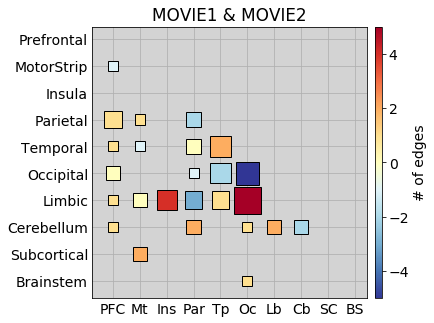

In [282]:
# clip = ["REST1", "REST4"]
clip = ["MOVIE1", "MOVIE2"] 
# clip = ["MOVIE3", "MOVIE4"]
thresh = 0.9

pos_mask, neg_mask = get_masks(clip=clip, thresh=thresh)
pos_summary, neg_summary = summarize_masks(pos_mask, neg_mask)

# fig, ax = plt.subplots()
mpl.rcParams.update({'font.size': 14})

fig, ax = hinton(pos_summary, neg_summary, figsize=(5,5)) #, ax=ax)
# ax.set_yticklabels([''] + pos_summary.index.tolist()) # add a blank label pad so labels appear in the right place
# ax.set_yticklabels([''] + ['FP', 'SC', 'DM', 'MF', 'Mt', 'VA', 'VI', 'VII'])
# ax.set_xticklabels([''] + ['FP', 'SC', 'DM', 'MF', 'Mt', 'VA', 'VI', 'VII'])

ax.set_yticklabels([''] + pos_summary.index.tolist())
ax.set_xticklabels([''] + ['PFC', 'Mt', 'Ins', 'Par', 'Tp', 'Oc', 'Lb', 'Cb', 'SC', 'BS'])

if type(clip)==str:
    title = clip
elif type(clip)==list:
    title = [clip[0] + ''.join([' & ', x]) for x in clip[1:]][0]
    
ax.set_title(title)
# fig.set_size_inches(8,8)
plt.show()
fig.savefig(title + '_' + behav + '_Hinton.jpg', dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

## Draw overlap matrix

In [79]:
thresh = 0.9
type_order = ["REST1", "REST4", "MOVIE1", "MOVIE2", "MOVIE3", "MOVIE4"]

df_overlap = pd.DataFrame(index=type_order, columns=type_order)
df_pvals = pd.DataFrame(index=type_order, columns=type_order)

for r1,run1 in enumerate(type_order):
    for r2,run2 in enumerate(type_order):
        
        if r1!=r2:
            
            masked_1 = (mask_dict[run1]["pos_mask"] + mask_dict[run1]["neg_mask"]) > thresh
            masked_2 = (mask_dict[run2]["pos_mask"] + mask_dict[run2]["neg_mask"]) > thresh
            
            # for hypergeom cdf:
            n_edges_mask1 = masked_1.sum()
            n_edges_mask2 = masked_2.sum()
            n_overlap = np.logical_and(masked_1, masked_2).sum()
            n_edges = mask_dict[run1]["pos_mask"].shape[0]

            df_overlap.loc[run1, run2] = n_overlap
            df_pvals.loc[run1, run2] = 1 - sp.stats.hypergeom.cdf(n_overlap, n_edges, n_edges_mask1, n_edges_mask2)
        
        elif r1==r2:
            df_overlap.loc[run1, run2] = np.nan
            df_pvals.loc[run1, run2] = np.nan

In [80]:
df_overlap

,REST1,REST4,MOVIE1,MOVIE2,MOVIE3,MOVIE4
REST1,NaN,42,24,19,14,14
REST4,42,NaN,9,13,10,8
MOVIE1,24,9,NaN,58,31,30
MOVIE2,19,13,58,NaN,27,27
MOVIE3,14,10,31,27,NaN,37
MOVIE4,14,8,30,27,37,NaN


In [81]:
df_pvals

,REST1,REST4,MOVIE1,MOVIE2,MOVIE3,MOVIE4
REST1,NaN,0,0,0.0229792,2.64411e-07,2.78987e-08
REST4,0,NaN,2.77018e-06,0.000763332,4.83023e-08,1.04965e-06
MOVIE1,0,2.77022e-06,NaN,2.77196e-11,0,0
MOVIE2,0.0229792,0.000763332,1.16007e-11,NaN,1.23728e-09,5.55911e-11
MOVIE3,2.64425e-07,4.83163e-08,0,1.24384e-09,NaN,0
MOVIE4,2.78914e-08,1.04966e-06,0,3.91832e-11,0,NaN


In [82]:
# Bonferroni correction
n_comparisons = len(np.triu_indices_from(df_pvals, k=1)[0])
df_pvals = df_pvals*n_comparisons

df_pvals

,REST1,REST4,MOVIE1,MOVIE2,MOVIE3,MOVIE4
REST1,NaN,0,0,0.344688,3.96617e-06,4.18481e-07
REST4,0,NaN,4.15527e-05,0.01145,7.24534e-07,1.57447e-05
MOVIE1,0,4.15533e-05,NaN,4.15794e-10,0,0
MOVIE2,0.344688,0.01145,1.74011e-10,NaN,1.85592e-08,8.33866e-10
MOVIE3,3.96638e-06,7.24745e-07,0,1.86576e-08,NaN,0
MOVIE4,4.18371e-07,1.57449e-05,0,5.87748e-10,0,NaN


In [83]:
df_annot = df_pvals.copy()

df_annot[df_pvals > 0.05] = 'n.s.'
df_annot[(0.05 > df_pvals) & (df_pvals > 0.01)] = '*'
df_annot[(0.01 > df_pvals) & (df_pvals > 0.001)] = '**'
df_annot[(0.001 > df_pvals) & (df_pvals > 0.0001)] = '***'
df_annot[(0.0001 > df_pvals)] = '****'

[Text(0.5, 0, 'R1'),
 Text(1.5, 0, 'R4'),
 Text(2.5, 0, 'M1'),
 Text(3.5, 0, 'M2'),
 Text(4.5, 0, 'M3'),
 Text(5.5, 0, 'M4')]

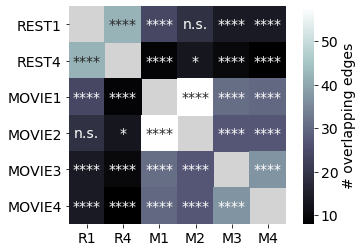

In [85]:
mpl.rcParams.update({'font.size': 14})

np.fill_diagonal(df_overlap.values, np.nan)
g = sns.heatmap(df_overlap.astype(float), square=True, cmap='bone', cbar_kws={'label': '# overlapping edges'},
               annot=df_annot, fmt='s')
g.set_facecolor("lightgray")
g.set_xticklabels(['R1', 'R4', 'M1', 'M2', 'M3', 'M4'], rotation=0)

In [74]:
rest_state = ["REST1", "REST4"]
movie_state = ["MOVIE1", "MOVIE2", "MOVIE3", "MOVIE4"]

within_state_pairs = list(itertools.combinations(rest_state,2)) + list(itertools.combinations(movie_state,2))
across_state_pairs = list(itertools.product(rest_state, movie_state))

print(within_state_pairs)
print(across_state_pairs)

[('REST1', 'REST4'), ('MOVIE1', 'MOVIE2'), ('MOVIE1', 'MOVIE3'), ('MOVIE1', 'MOVIE4'), ('MOVIE2', 'MOVIE3'), ('MOVIE2', 'MOVIE4'), ('MOVIE3', 'MOVIE4')]
[('REST1', 'MOVIE1'), ('REST1', 'MOVIE2'), ('REST1', 'MOVIE3'), ('REST1', 'MOVIE4'), ('REST4', 'MOVIE1'), ('REST4', 'MOVIE2'), ('REST4', 'MOVIE3'), ('REST4', 'MOVIE4')]


In [76]:
n_iter = 1000

within_state_overlaps = []
across_state_overlaps = []

for pair in within_state_pairs:
    run1 = pair[0]
    run2 = pair[1]
    arr1 = (mask_dict[run1]["pos_mask"] + mask_dict[run1]["neg_mask"]) > thresh
    arr2 = (mask_dict[run2]["pos_mask"] + mask_dict[run2]["neg_mask"]) > thresh
    overlap = arr_overlap(arr1, arr2)
    within_state_overlaps.append(overlap)

for pair in across_state_pairs:
    run1 = pair[0]
    run2 = pair[1]
    arr1 = (mask_dict[run1]["pos_mask"] + mask_dict[run1]["neg_mask"]) > thresh
    arr2 = (mask_dict[run2]["pos_mask"] + mask_dict[run2]["neg_mask"]) > thresh
    overlap = arr_overlap(arr1, arr2)
    across_state_overlaps.append(overlap)
    
print(within_state_overlaps)
print(np.mean(within_state_overlaps))

print(across_state_overlaps)
print(np.mean(across_state_overlaps))

[42, 58, 31, 30, 27, 27, 37]
36.0
[24, 19, 14, 14, 9, 13, 10, 8]
13.875


(array([2., 1., 0., 3., 0., 0., 1., 0., 0., 1.]),
 array([ 8. ,  9.6, 11.2, 12.8, 14.4, 16. , 17.6, 19.2, 20.8, 22.4, 24. ]),
 <a list of 10 Patch objects>)

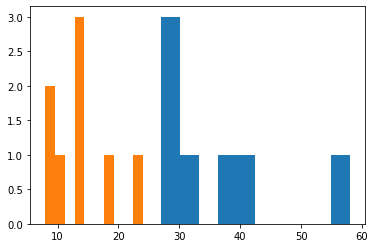

In [77]:
plt.hist(within_state_overlaps)
plt.hist(across_state_overlaps)

In [78]:
sp.stats.mannwhitneyu(within_state_overlaps, across_state_overlaps)

MannwhitneyuResult(statistic=0.0, pvalue=0.0007157952413006761)

## Compare edges selected for COGN vs EMOT in Oceans and SocialNet

Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)


/data/finnes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


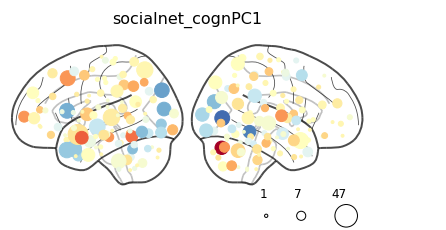

In [187]:
clip="socialnet"
behav="cognPC1"
gsr="1"
zscore="0"
trs=143
norm_size=True
size_factor = 400 # 20 is a good one if norm_size=False, 200 is a good one if norm_size=True
add_cbar=False
# ----------------------------------------------------------------------------------------------
fig = plt.figure(figsize=(5,3))

pos_mask, neg_mask = load_masks(clip=clip, behav=behav, gsr=gsr, zscore=zscore, trs=trs)
fig, cmap, norm, combo_mask, n_edges, node_size = plot_important_nodes(pos_mask, neg_mask, fig=fig, thresh=0.9, norm_size=norm_size, size_factor=size_factor)
# fig.suptitle(clip + "_" + behav)
fig.suptitle(clip + "_" + behav, fontsize=16)
             
# make separate colorbar
if add_cbar is True:
    ax2 = fig.add_axes([0,0,0.5,0.1])
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(['More\n-ve edges', 'Equal\n+ve/-ve', 'More\n+ve edges'])
    cbar.ax.tick_params(labelsize='large')


# draw size key
ax3 = fig.add_axes([0.7,0,0.5,0.02])
ada = AnchoredDrawingArea(100, 5, 0, 0,
                          loc='lower left', pad=0., frameon=False)

ax3.axis('off')

# if norm_size is True:
#     max_edges = int(np.max(((node_size/size_factor)*max(abs(node_size))))
#     min_edges = int(np.min(node_size[node_size > 0]/size_factor*max(abs(node_size))))
#     mean_edges = int(np.mean(node_size[node_size > 0]/size_factor*max(abs(node_size))))
# if norm_size is False:
#    max_edges = int(np.max(node_size/size_factor))
#     min_edges = int(np.min(node_size[node_size > 0]/size_factor))
#     mean_edges = int(np.mean(node_size[node_size > 0]/size_factor))


max_edges = int(np.max(n_edges))
min_edges = int(np.min(n_edges[n_edges > 0]))
mean_edges = int(np.mean(n_edges[n_edges > 0]))

r_max = np.sqrt(np.max(node_size)/math.pi)
r_min = np.sqrt(np.min(node_size[node_size > 0])/math.pi)
r_mean = np.sqrt(np.mean(node_size[node_size > 0])/math.pi)

p1 = Circle((0, 0), r_min, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p1)
p2 = Circle((35, 0), r_mean, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p2)
p3 = Circle((80, 0), r_max, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p3)

ax3.add_artist(ada)

fontsize=12
ax3.annotate(str(min_edges), 
                xy=(0, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='left')
             
ax3.annotate(str(mean_edges), 
                xy=(35, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='left')
             
ax3.annotate(str(max_edges), 
                xy=(80, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='center')

# ax3.text(0.3, 0.8, 'Number of edges', verticalalignment='bottom', horizontalalignment='center', transform=ax3.transAxes, fontsize=fontsize)

#ax3.text('Number of edges', 
#                   xy=(25, 2), 
#                   xycoords='axes pixels')

fig.tight_layout()

In [191]:
clips=["socialnet", "oceans"]
behavs=["cognPC1", "emotPC1"]
thresh = 0.9
gsr="1"
zscore="0"
trs=143

combos = list(itertools.product(behavs, clips))

names = [''.join([x,'_',y]) for x in behavs for y in clips]

df_overlap = pd.DataFrame(index=names, columns=names)
df_pvals = pd.DataFrame(index=names, columns=names)

for b1,behav1 in enumerate(behavs):
    for b2,behav2 in enumerate(behavs):
        for c1,clip1 in enumerate(clips):
            for c2,clip2 in enumerate(clips):
                print(f"doing {clip1}-{clip2}-{behav1}-{behav2}")

                pos_mask1, neg_mask1 = load_masks(clip=clip1, behav=behav1, gsr=gsr, zscore=zscore, trs=trs)
                pos_mask2, neg_mask2 = load_masks(clip=clip2, behav=behav2, gsr=gsr, zscore=zscore, trs=trs)
                
                n_edges = pos_mask1.shape[0]
                n_edges_mask1 = (pos_mask1 + neg_mask1 > thresh).sum()
                n_edges_mask2 = (pos_mask2 + neg_mask2 > thresh).sum()
                n_overlap = np.logical_and((pos_mask1 + neg_mask1 > thresh), (pos_mask2 + neg_mask2 > thresh)).sum()
                
                df_overlap.loc[behav1+'_'+clip1, behav2+'_'+clip2] = n_overlap
                df_pvals.loc[behav1+'_'+clip1, behav2+'_'+clip2] = 1 - sp.stats.hypergeom.cdf(n_overlap, n_edges, n_edges_mask1, n_edges_mask2)

doing socialnet-socialnet-cognPC1-cognPC1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
doing socialnet-oceans-cognPC1-cognPC1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
doing oceans-socialnet-cognPC1-cognPC1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
doing oceans-oceans-cognPC1-cognPC1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
doing socialnet-socialnet-cognPC1-emotPC1
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)


In [192]:
df_overlap

,cognPC1_socialnet,cognPC1_oceans,emotPC1_socialnet,emotPC1_oceans
cognPC1_socialnet,823,82,9,15
cognPC1_oceans,82,426,2,7
emotPC1_socialnet,9,2,235,23
emotPC1_oceans,15,7,23,209


In [193]:
df_pvals

,cognPC1_socialnet,cognPC1_oceans,emotPC1_socialnet,emotPC1_oceans
cognPC1_socialnet,0,0,0.0464363,3.0453e-05
cognPC1_oceans,2.92792e-11,0,0.531853,0.00375443
emotPC1_socialnet,0.0464363,0.531853,0,2.84508e-11
emotPC1_oceans,3.0453e-05,0.00375443,1.4153e-11,0


In [212]:
df_annot = df_pvals.copy()
df_annot[df_pvals > 0.05] = 'n.s.'
df_annot[(0.05 > df_pvals) & (df_pvals > 0.01)] = '*'
df_annot[(0.01 > df_pvals) & (df_pvals > 0.001)] = '**'
df_annot[(0.001 > df_pvals) & (df_pvals > 0.0001)] = '***'
df_annot[(0.0001 > df_pvals)] = '****'

df_annot

,cognPC1_socialnet,cognPC1_oceans,emotPC1_socialnet,emotPC1_oceans
cognPC1_socialnet,****,****,*,****
cognPC1_oceans,****,****,n.s.,**
emotPC1_socialnet,*,n.s.,****,****
emotPC1_oceans,****,**,****,****


[Text(0, 0.5, 'Soc Net'),
 Text(0, 1.5, 'Oceans'),
 Text(0, 2.5, 'Soc Net'),
 Text(0, 3.5, 'Oceans')]

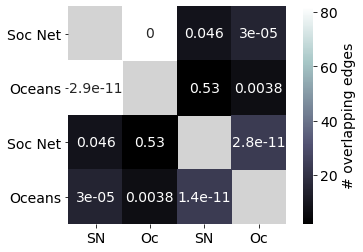

In [213]:
mpl.rcParams.update({'font.size': 14})

np.fill_diagonal(df_overlap.values, np.nan)
g = sns.heatmap(df_overlap.astype(float), square=True, cmap='bone', cbar_kws={'label': '# overlapping edges'},
               annot=df_pvals)
g.set_facecolor("lightgray")
g.set_xticklabels(['SN', 'Oc', 'SN', 'Oc'], rotation=0)
g.set_yticklabels(['Soc Net', 'Oceans', 'Soc Net', 'Oceans'], rotation=0)

[Text(0, 0.5, 'Soc Net'),
 Text(0, 1.5, 'Oceans'),
 Text(0, 2.5, 'Soc Net'),
 Text(0, 3.5, 'Oceans')]

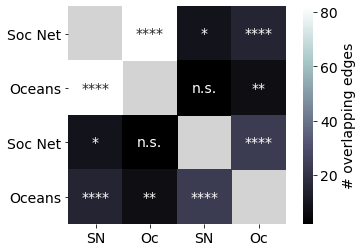

In [214]:
np.fill_diagonal(df_overlap.values, np.nan)
g = sns.heatmap(df_overlap.astype(float), square=True, cmap='bone', cbar_kws={'label': '# overlapping edges'},
               annot=df_annot, fmt='s')
g.set_facecolor("lightgray")
g.set_xticklabels(['SN', 'Oc', 'SN', 'Oc'], rotation=0)
g.set_yticklabels(['Soc Net', 'Oceans', 'Soc Net', 'Oceans'], rotation=0)

In [ ]:
behav="cognPC1"
gsr="1"
zscore="0"
trs= 143

pos_mask1, neg_mask1 = load_masks(clip="socialnet", behav=behav, gsr=gsr, zscore=zscore, trs=trs)
pos_mask2, neg_mask2 = load_masks(clip="oceans", behav=behav, gsr=gsr, zscore=zscore, trs=trs)

thresh = 0.9
                         
pos_mask = (pos_mask1 > thresh) & (pos_mask2 > thresh)
neg_mask = (neg_mask1 > thresh) & (neg_mask2 > thresh)

fig = plot_important_nodes(pos_mask, neg_mask, thresh=None, 
                           size_factor=500, norm_size=True, 
                           draw_edges=True, display_mode='lr')

Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
Shape of pos mask: (100, 35778)
Shape of neg mask: (100, 35778)
(35778,)
(35778,)
No. pos edges: 12
No. neg edges: 11
Total edges: 23


/data/finnes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


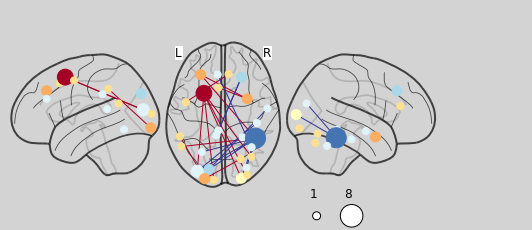

In [232]:
behav="emotPC1"
gsr="1"
zscore="0"
trs=143
norm_size=True
size_factor = 400 # 20 is a good one if norm_size=False, 200 is a good one if norm_size=True
add_cbar=False
title="Emotion score"
facecolor='lightgray'
# ----------------------------------------------------------------------------------------------

fig = plt.figure(figsize=(6,3), facecolor=facecolor)

pos_mask1, neg_mask1 = load_masks(clip="socialnet", behav=behav, gsr=gsr, zscore=zscore, trs=trs)
pos_mask2, neg_mask2 = load_masks(clip="oceans", behav=behav, gsr=gsr, zscore=zscore, trs=trs)

thresh = 0.9
                         
pos_mask = (pos_mask1 > thresh) & (pos_mask2 > thresh)
neg_mask = (neg_mask1 > thresh) & (neg_mask2 > thresh)

print(f"No. pos edges: {pos_mask.sum()}")
print(f"No. neg edges: {neg_mask.sum()}")
print(f"Total edges: {pos_mask.sum() + neg_mask.sum()}")


fig, cmap, norm, combo_mask, n_edges, node_size = plot_important_nodes(pos_mask, neg_mask, 
                                                                       fig=fig, thresh=None, 
                                                                       norm_size=norm_size, 
                                                                       size_factor=size_factor,
                                                                      draw_edges=True,
                                                                      display_mode='lzr')
# fig.suptitle(title, fontsize=16)
             
# make separate colorbar
if add_cbar is True:
    ax2 = fig.add_axes([0,0,0.5,0.1])
    cbar = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
                                    norm=norm,
                                    orientation='horizontal')
    cbar.set_ticks([-1, 0, 1])
    cbar.set_ticklabels(['More\n-ve edges', 'Equal\n+ve/-ve', 'More\n+ve edges'])
    cbar.ax.tick_params(labelsize='large')


# draw size key
ax3 = fig.add_axes([0.7,0,0.5,0.02])
ada = AnchoredDrawingArea(100, 5, 0, 0,
                          loc='lower left', pad=0., frameon=False)

ax3.axis('off')

# if norm_size is True:
#     max_edges = int(np.max(((node_size/size_factor)*max(abs(node_size))))
#     min_edges = int(np.min(node_size[node_size > 0]/size_factor*max(abs(node_size))))
#     mean_edges = int(np.mean(node_size[node_size > 0]/size_factor*max(abs(node_size))))
# if norm_size is False:
#    max_edges = int(np.max(node_size/size_factor))
#     min_edges = int(np.min(node_size[node_size > 0]/size_factor))
#     mean_edges = int(np.mean(node_size[node_size > 0]/size_factor))


max_edges = int(np.max(n_edges))
min_edges = int(np.min(n_edges[n_edges > 0]))
mean_edges = int(np.mean(n_edges[n_edges > 0]))

r_max = np.sqrt(np.max(node_size)/math.pi)
r_min = np.sqrt(np.min(node_size[node_size > 0])/math.pi)
r_mean = np.sqrt(np.mean(node_size[node_size > 0])/math.pi)

p1 = Circle((0, 0), r_min, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p1)
p2 = Circle((35, 0), r_max, edgecolor = 'black', facecolor='white')
ada.drawing_area.add_artist(p2)

ax3.add_artist(ada)

fontsize=12
ax3.annotate(str(min_edges), 
                xy=(0, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='left')
             
ax3.annotate(str(max_edges), 
                xy=(35, 25), 
                xycoords='axes points', 
             fontsize=fontsize, horizontalalignment='left')
             
# ax3.text(0.3, 0.8, 'Number of edges', verticalalignment='bottom', horizontalalignment='center', transform=ax3.transAxes, fontsize=fontsize)

#ax3.text('Number of edges', 
#                   xy=(25, 2), 
#                   xycoords='axes pixels')

fig.tight_layout()
plt.savefig('socialnet_oceans_overlap_thr-'+str(thresh)+'_'+behav+'.jpg', dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())